In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import cv2 
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sn 
import pandas as pd 
import pickle  
import csv 

from sklearn.metrics import confusion_matrix, classification_report 
import tensorflow as tf 
from PIL import Image 
from tensorflow.keras import layers 

In [ ]:
path_base = '/content/drive/MyDrive/Colab Notebooks/ALL/Segmented/'

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro'] #available classes
num_classes=4

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
import os

In [ ]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [ ]:
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
img_width, img_height = 224, 224
img_shape = (224,224)
epochs = 10
batch_size = 32
n_classes = 4

In [ ]:
benign = []
early = [] 
pre = []
pro = []
b,e,pe,po = 0,0,0,0

In [ ]:
for i in os.scandir('/content/drive/MyDrive/Colab Notebooks/ALL/Segmented/Benign'):
    img = cv2.imread(i.path)
    img = cv2.resize(img, (128,128))
    benign.append(img)
    b +=1
    if b == 500:
        break

In [ ]:
for i in os.scandir('/content/drive/MyDrive/Colab Notebooks/ALL/Segmented/Early'):
    img = cv2.imread(i.path)
    img = cv2.resize(img, (128,128))
    early.append(img)
    e +=1
    if e == 500:
        break

In [ ]:
for i in os.scandir('/content/drive/MyDrive/Colab Notebooks/ALL/Segmented/Pre'):
    img = cv2.imread(i.path)
    img = cv2.resize(img, (128,128))
    pre.append(img)   
    pe +=1 
    if pe == 500:
        break

In [ ]:
for i in os.scandir('/content/drive/MyDrive/Colab Notebooks/ALL/Segmented/Pro'):
    img = cv2.imread(i.path)
    img = cv2.resize(img, (128,128))
    pro.append(img)   
    po +=1 
    if po == 500:
        break

In [ ]:
benign = np.array(benign)
early = np.array(early)
pre = np.array(pre)
pro = np.array(pro)

In [ ]:
print(benign.shape, early.shape, pre.shape, pro.shape)

(500, 128, 128, 3) (500, 128, 128, 3) (500, 128, 128, 3) (500, 128, 128, 3)


In [ ]:
X = np.concatenate((benign, early, pre, pro), axis = 0)

In [ ]:
Y = np.zeros((2000, 1))
for i in range(2000):
    if i<500:
        Y[i] = 0
    elif i<1000:
        Y[i] = 1
    elif i<1500:
        Y[i] = 2
    else:
        Y[i] = 3

In [ ]:
from tensorflow.keras.utils import to_categorical
Y = to_categorical(Y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 3, test_size = 0.3)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1) 
print(X_train.shape, X_test.shape, Y_val.shape, Y_train.shape, Y_test.shape, Y_val.shape)

(1050, 128, 128, 3) (600, 128, 128, 3) (350, 4) (1050, 4) (600, 4) (350, 4)


In [ ]:
def densenet(img_shape = (128,128,3), n_classes=4, f=32):
  repetitions = 6,6
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
model = densenet()
#model.summary()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow import keras
from tensorflow.keras.models import *
import cv2
import skimage.io
import io
import os
from google.colab.patches import cv2_imshow

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adamax(0.0001), metrics = ['accuracy'])
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 30, batch_size = 64, shuffle = True)

Epoch 1/30
17/17 [==============================] - 10s 362ms/step - loss: 1.0168 - accuracy: 0.5886 - val_loss: 2.4044 - val_accuracy: 0.2829
Epoch 2/30
17/17 [==============================] - 5s 278ms/step - loss: 0.7409 - accuracy: 0.7810 - val_loss: 2.0298 - val_accuracy: 0.3657
Epoch 3/30
17/17 [==============================] - 5s 278ms/step - loss: 0.6340 - accuracy: 0.7981 - val_loss: 1.6568 - val_accuracy: 0.4486
Epoch 4/30
17/17 [==============================] - 5s 274ms/step - loss: 0.5466 - accuracy: 0.8410 - val_loss: 1.4174 - val_accuracy: 0.4457
Epoch 5/30
17/17 [==============================] - 5s 274ms/step - loss: 0.4904 - accuracy: 0.8524 - val_loss: 1.1698 - val_accuracy: 0.4714
Epoch 6/30
17/17 [==============================] - 5s 275ms/step - loss: 0.4354 - accuracy: 0.8762 - val_loss: 1.1084 - val_accuracy: 0.5229
Epoch 7/30
17/17 [==============================] - 5s 294ms/step - loss: 0.3886 - accuracy: 0.9038 - val_loss: 0.9138 - val_accuracy: 0.6457
Epoch

In [ ]:
old_model = load_model ('/content/drive/MyDrive/Colab Notebooks/dense_model.h5')

In [ ]:
tf.keras.utils.plot_model(old_model, show_shapes=True)

In [ ]:
old_model.summary()

In [ ]:
train_perf = old_model.evaluate(X_train, Y_train)
test_perf = old_model.evaluate(X_test, Y_test)
val_perf = old_model.evaluate(X_val, Y_val)

11/11 [==============================] - 1s 60ms/step - loss: 0.0883 - accuracy: 0.9543


In [ ]:
lr_probs = old_model.predict_on_batch(X_test)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], lr_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), lr_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

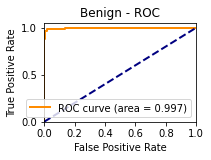

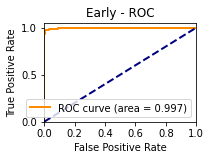

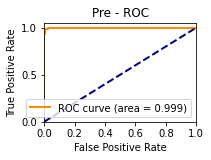

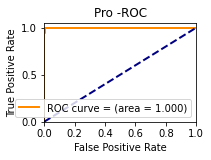

In [ ]:
plt.figure()
lw = 2
plt.subplot(2,2,1)
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.3f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Benign - ROC")
plt.legend(loc="lower right")
plt.show()

plt.subplot(2,2,2)
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.3f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Early - ROC")
plt.legend(loc="lower right")
plt.show()

plt.subplot(2,2,3)
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.3f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pre - ROC")
plt.legend(loc="lower right")
plt.show()


plt.subplot(2,2,4)
plt.plot(
    fpr[3],
    tpr[3],
    color="darkorange",
    lw=lw,
    label="ROC curve = (area = %0.3f)" % roc_auc[3],
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pro -ROC")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc

{0: 0.9965477723227549,
 1: 0.9968171871891784,
 2: 0.9989288516082312,
 3: 0.9996740740740742,
 'micro': 0.9980601851851851}

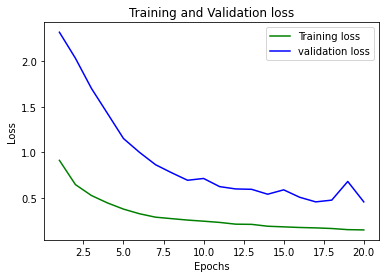

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

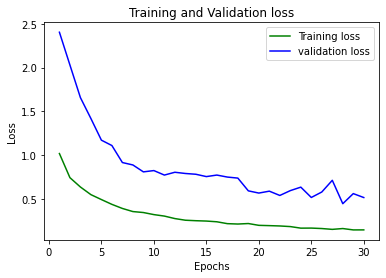

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

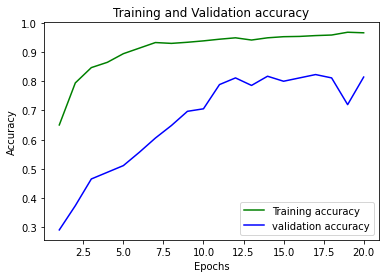

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

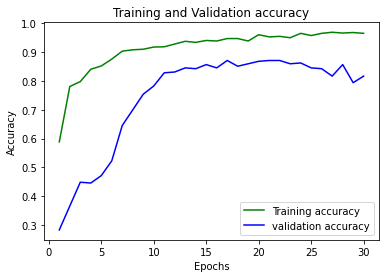

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
! which python 

/usr/local/bin/python


In [ ]:
train_perf = model.evaluate(X_train, Y_train)
test_perf = model.evaluate(X_test, Y_test)
val_perf = model.evaluate(X_val, Y_val)

11/11 [==============================] - 1s 95ms/step - loss: 0.2211 - accuracy: 0.9229


In [ ]:
from sklearn.metrics import confusion_matrix
predicted = old_model.predict(X_test)
predicted = np.round(predicted)

In [ ]:
a = predicted.argmax(1)
a.shape

(600,)

In [ ]:
a = a+1

In [ ]:
t = Y_test.argmax(1)

In [ ]:
t = t+1

In [ ]:
cm = confusion_matrix(a,t, labels=[1,2,3,4])
print(cm)

[[155   5   1   0]
 [  2 135   1   0]
 [  0   3 142   0]
 [  4   0   2 150]]


In [ ]:
def LeukModel(input_size = (128, 128, 3)):
    inpu = Input(shape = input_size)

    conv0 = Conv2D(8, (3, 3), activation = 'relu') (inpu)
    maxpool0 = MaxPooling2D((2,2)) (conv0)
    drop0 = Dropout(0.4) (maxpool0)
    
    conv1 = Conv2D(16, (3, 3), activation = 'relu') (drop0)
    maxpool1 = MaxPooling2D((2,2)) (conv1)
    drop1 = Dropout(0.4) (maxpool1)
    
    conv2 = Conv2D(32, (3, 3), activation = 'relu') (drop1)
    maxpool2 = MaxPooling2D((2, 2)) (conv2)
    drop2 = Dropout(0.4) (maxpool2)
    
    conv3 = Conv2D(64, (3, 3), activation = 'relu') (drop2)
    maxpool3 = MaxPooling2D((2, 2)) (conv3)
    drop3 = Dropout(0.4) (maxpool3)
    
    flat = Flatten() (drop3)
    
    dense1 = Dense(256, activation = 'relu') (flat)
    dense2 = Dense(128, activation = 'relu') (dense1)
    dense3 = Dense(64, activation = 'relu') (dense2)
    op = Dense(4, activation = 'sigmoid') (dense3)
    
    model = Model(inpu, op)
    
    return model

In [ ]:
Leukmodel = LeukModel()
Leukmodel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_136 (Conv2D)         (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 8)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 8)         0         
                                                                 
 conv2d_137 (Conv2D)         (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                       

In [ ]:
Leukmodel.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(0.001), metrics = ['accuracy'])
history = Leukmodel.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 40, batch_size = 32, shuffle = True)

Epoch 1/40
33/33 [==============================] - 2s 37ms/step - loss: 7.7943 - accuracy: 0.2581 - val_loss: 1.3396 - val_accuracy: 0.3286
Epoch 2/40
33/33 [==============================] - 1s 20ms/step - loss: 1.4047 - accuracy: 0.3019 - val_loss: 1.3253 - val_accuracy: 0.4429
Epoch 3/40
33/33 [==============================] - 1s 21ms/step - loss: 1.3547 - accuracy: 0.3390 - val_loss: 1.3010 - val_accuracy: 0.4857
Epoch 4/40
33/33 [==============================] - 1s 20ms/step - loss: 1.2790 - accuracy: 0.3895 - val_loss: 1.2900 - val_accuracy: 0.4943
Epoch 5/40
33/33 [==============================] - 1s 22ms/step - loss: 1.2305 - accuracy: 0.4314 - val_loss: 1.2413 - val_accuracy: 0.5200
Epoch 6/40
33/33 [==============================] - 1s 22ms/step - loss: 1.1787 - accuracy: 0.4590 - val_loss: 1.1939 - val_accuracy: 0.5714
Epoch 7/40
33/33 [==============================] - 1s 22ms/step - loss: 1.1443 - accuracy: 0.4933 - val_loss: 1.1576 - val_accuracy: 0.5200
Epoch 8/40
33

In [ ]:
train_perf = Leukmodel.evaluate(X_train, Y_train)
test_perf = Leukmodel.evaluate(X_test, Y_test)
val_perf = Leukmodel.evaluate(X_val, Y_val)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/dense_model.h5') 